In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
import plotnine as p9


In [2]:
X_train = pd.read_csv("./data/external/train_logs.csv")

In [3]:
y_train = pd.read_csv("./data/external/train_scores.csv")

In [4]:
X_train.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [5]:
X_train.shape

(8405898, 11)

In [6]:
X_train.dtypes

id                 object
event_id            int64
down_time           int64
up_time             int64
action_time         int64
activity           object
down_event         object
up_event           object
text_change        object
cursor_position     int64
word_count          int64
dtype: object

In [7]:
X_train.isnull().mean()

id                 0.0
event_id           0.0
down_time          0.0
up_time            0.0
action_time        0.0
activity           0.0
down_event         0.0
up_event           0.0
text_change        0.0
cursor_position    0.0
word_count         0.0
dtype: float64

In [8]:
assert(all(X_train[['id', 'event_id']].value_counts() == 1))

In [9]:
# problem: what kind of "events" happen per "activity"?
X_train_sub = X_train.loc[X_train['id'] == '001519c8']

# narrative for this case:
    # Type 12 words with only a couple isolated deletes.
    # "Delete burst" -- of increased scale relative to isolated deletes
    # write 6 more words
    # click the mouse several times -- thinking?


# how do "Nonproduction" activities map to literature concepts?
    # these cases probably need scrubbed when thinking about total keystroke activity.
# two Remove/Cut activity, with equal down_event & up_event, may have different text_change. why?
    # ah -- deleting a space, versus deleting a written character

# Nonproduction-Leftclick: navigate with mouse, then click to specify new cursor position
    
# "activity" is a higher-level summary of an "event"
    # multiple events qualify as a single "activity"

In [10]:
# no explicit record for a pause. pauses are omitted.
X_train_sub = (
    X_train_sub
    .sort_values(["id", "event_id"], ascending=[True, True])
    )

X_train_sub['up_time_lag1'] = (
    X_train_sub
    .groupby(['id'])
    ['up_time']
    .shift(1)
    )

X_train_sub['preceding_pause_time'] = (
    X_train_sub['down_time'] - X_train_sub['up_time_lag1']
    )
# expect some negative pause times -- interpret as, no real pause
has_no_real_pause = X_train_sub['preceding_pause_time'] <= 0
X_train_sub.loc[has_no_real_pause, 'preceding_pause_time'] = None

# if pause exceeds threshold duration, a "burst" has ended
MS_PER_S = 1000
SECONDS_PER_BURST = 2

X_train_sub['is_new_burst_start'] = (
    X_train_sub['preceding_pause_time'] > MS_PER_S * SECONDS_PER_BURST
    ).astype(int)
X_train_sub['is_new_burst_start'][0] = 1
X_train_sub['burst_id'] = (
    X_train_sub
    .groupby(['id'])
    ['is_new_burst_start']
    .cumsum()
    )
X_train_sub['burst_time_start'] = (
    X_train_sub
    .groupby(['id', 'burst_id'])
    ['down_time']
    .transform('min')
    )
X_train_sub['burst_time_end'] = (
    X_train_sub
    .groupby(['id', 'burst_id'])
    ['up_time']
    .transform('max')
    )
X_train_sub['burst_duration'] = X_train_sub['burst_time_end'] - X_train_sub['burst_time_start']

# burst type?

C:\Users\alexa\AppData\Local\Temp\ipykernel_29680\2935678159.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
# windows allow for time-sequence features
TOTAL_MIN = 30
SECONDS_PER_MIN = 60
SECONDS_PER_WINDOW = 30

X_train_sub['window_30s'] = pd.cut(
    X_train_sub['down_time'],
    bins=np.arange(
        0, 
        TOTAL_MIN * SECONDS_PER_MIN * MS_PER_S + 5*MS_PER_S*2, 
        SECONDS_PER_WINDOW * MS_PER_S
        )
    )

# must ensure that time windows with 0 events still accounted for 
# in later tabulations
(
    X_train_sub['window_30s']
    .value_counts()
    .reset_index(drop=False)
    .sort_values('window_30s')
    .head(10)
)

,window_30s,count
53,"(0, 30000]",2
54,"(30000, 60000]",0
59,"(60000, 90000]",0
18,"(90000, 120000]",64
52,"(120000, 150000]",3
4,"(150000, 180000]",93
33,"(180000, 210000]",32
25,"(210000, 240000]",42
34,"(240000, 270000]",32
15,"(270000, 300000]",72


In [12]:
# summarize pause distr
MS_IN_PAUSE_BUCKET_MAX = 200e3
PAUSE_BUCKET_STEP_MS = 500

X_train_sub['preceding_pause_time_bucket'] = pd.cut(
    X_train_sub['preceding_pause_time'],
    bins=np.arange(
        0, 
        MS_IN_PAUSE_BUCKET_MAX,
        PAUSE_BUCKET_STEP_MS
        )
    )

X_train_sub['preceding_pause_time_bucket'].value_counts()

# WARNING: this representation of pause distribution is dense & large
# a few parameters from distribution model far more succinct


preceding_pause_time_bucket
(0.0, 500.0]            1334
(500.0, 1000.0]          116
(1000.0, 1500.0]          51
(1500.0, 2000.0]          30
(3000.0, 3500.0]          14
                        ... 
(76000.0, 76500.0]         0
(75500.0, 76000.0]         0
(75000.0, 75500.0]         0
(74500.0, 75000.0]         0
(199000.0, 199500.0]       0
Name: count, Length: 399, dtype: int64

In [13]:
ACTIVITY_CATEGORIES = ['Nonproduction', 'Input', 'Remove/Cut']

pipeline_activity_onehot = ColumnTransformer(
    transformers=[(
        'onehot_encode', 
        preprocessing.OneHotEncoder(
            categories=[ ACTIVITY_CATEGORIES ], 
            sparse=False, 
            handle_unknown='infrequent_if_exist'
            ),
        ["activity"]
    )],
    remainder='passthrough',
    verbose_feature_names_out=False
    )
pipeline_activity_onehot.fit(X_train_sub)
original_categorical = X_train_sub['activity']

X_train_sub_dtypes = X_train_sub.dtypes.to_dict()
X_train_sub = pipeline_activity_onehot.transform(X_train_sub)
X_train_sub = pd.DataFrame(X_train_sub, columns=pipeline_activity_onehot.get_feature_names_out())
X_train_sub = pd.concat([X_train_sub, original_categorical], axis=1)
X_train_sub = X_train_sub.astype(X_train_sub_dtypes)

c:\Users\alexa\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [14]:
for activity in ACTIVITY_CATEGORIES:

    X_train_sub['burst_action_time_' + activity] = (
        X_train_sub
        .assign(activity_x_event_time = lambda x: x['activity_' + activity] * x.action_time)
        .groupby(['id', 'burst_id'])
        ['activity_x_event_time']
        .transform('sum')
        ).astype(float)
    
X_train_sub['burst_type'] = (
    X_train_sub
    [['burst_action_time_' + activity for activity in ACTIVITY_CATEGORIES]]
    .idxmax(axis=1)
    )
X_train_sub['burst_type'] = (
    X_train_sub['burst_type']
    .str
    .replace("burst_action_time_", "", regex=True)
    )

In [15]:
ACTIVITY_CATEGORIES = ['Nonproduction', 'Input', 'Remove/Cut']

pipeline_burst_type_onehot = ColumnTransformer(
    transformers=[(
        'onehot_encode', 
        preprocessing.OneHotEncoder(
            categories=[ ACTIVITY_CATEGORIES ], 
            sparse=False, 
            handle_unknown='infrequent_if_exist'
            ),
        ["burst_type"]
    )],
    remainder='passthrough',
    verbose_feature_names_out=False
    )
pipeline_burst_type_onehot.fit(X_train_sub)
original_categorical = X_train_sub['burst_type']

X_train_sub_dtypes = X_train_sub.dtypes.to_dict()
X_train_sub = pipeline_burst_type_onehot.transform(X_train_sub)
X_train_sub = pd.DataFrame(X_train_sub, columns=pipeline_burst_type_onehot.get_feature_names_out())
X_train_sub = pd.concat([X_train_sub, original_categorical], axis=1)
X_train_sub = X_train_sub.astype(X_train_sub_dtypes)

c:\Users\alexa\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [16]:
for activity in ACTIVITY_CATEGORIES:

    X_train_sub['is_new_burst_start_' + activity] = (
        X_train_sub['is_new_burst_start'] * 
        X_train_sub['burst_type_' + activity]
        )

In [17]:
X_train_sub = X_train_sub[[
    "id",
    "event_id",
    "window_30s",
    "burst_id",
    "burst_type",
    "burst_type_Nonproduction",
    "burst_type_Input",
    "burst_type_Remove/Cut",
    "is_new_burst_start",
    "is_new_burst_start_Nonproduction",
    "is_new_burst_start_Input",
    "is_new_burst_start_Remove/Cut",
    "burst_time_start",
    "burst_time_end",
    "burst_duration",

    "down_time",
    "up_time",	
    "action_time",	
    "activity",	
    "activity_Nonproduction",
    "activity_Input",
    "activity_Remove/Cut",
    "down_event",	
    "up_event",	
    "text_change",
    "cursor_position",	
    "word_count",

    "up_time_lag1",
    "preceding_pause_time",
    "preceding_pause_time_bucket",

    "burst_action_time_Nonproduction",
    "burst_action_time_Input",
    "burst_action_time_Remove/Cut"
    ]]


In [18]:
X_train_sub.to_csv("./data/interim/train_logs_case_enriched.csv", index=False)

In [19]:
X_train_sub.head(10)

,id,event_id,window_30s,burst_id,burst_type,burst_type_Nonproduction,burst_type_Input,burst_type_Remove/Cut,is_new_burst_start,is_new_burst_start_Nonproduction,...,up_event,text_change,cursor_position,word_count,up_time_lag1,preceding_pause_time,preceding_pause_time_bucket,burst_action_time_Nonproduction,burst_action_time_Input,burst_action_time_Remove/Cut
0,001519c8,1,"(0, 30000]",1,Nonproduction,1.0,0.0,0.0,1,1.0,...,Leftclick,NoChange,0,0,NaN,NaN,NaN,435.0,0.0,0.0
1,001519c8,2,"(0, 30000]",1,Nonproduction,1.0,0.0,0.0,0,0.0,...,Leftclick,NoChange,0,0,4557.0,1.0,"(0.0, 500.0]",435.0,0.0,0.0
2,001519c8,3,"(90000, 120000]",2,Input,0.0,1.0,0.0,1,0.0,...,Shift,NoChange,0,0,4962.0,101609.0,"(101500.0, 102000.0]",0.0,7814.0,188.0
3,001519c8,4,"(90000, 120000]",2,Input,0.0,1.0,0.0,0,0.0,...,q,q,1,1,106571.0,115.0,"(0.0, 500.0]",0.0,7814.0,188.0
4,001519c8,5,"(90000, 120000]",2,Input,0.0,1.0,0.0,0,0.0,...,q,q,2,1,106777.0,419.0,"(0.0, 500.0]",0.0,7814.0,188.0
5,001519c8,6,"(90000, 120000]",2,Input,0.0,1.0,0.0,0,0.0,...,q,q,3,1,107323.0,NaN,NaN,0.0,7814.0,188.0
6,001519c8,7,"(90000, 120000]",2,Input,0.0,1.0,0.0,0,0.0,...,q,q,4,1,107400.0,69.0,"(0.0, 500.0]",0.0,7814.0,188.0
7,001519c8,8,"(90000, 120000]",2,Input,0.0,1.0,0.0,0,0.0,...,q,q,5,1,107596.0,63.0,"(0.0, 500.0]",0.0,7814.0,188.0
8,001519c8,9,"(90000, 120000]",2,Input,0.0,1.0,0.0,0,0.0,...,q,q,6,1,107766.0,NaN,NaN,0.0,7814.0,188.0
9,001519c8,10,"(90000, 120000]",2,Input,0.0,1.0,0.0,0,0.0,...,Space,,7,1,107852.0,NaN,NaN,0.0,7814.0,188.0


c:\Users\alexa\Anaconda3\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_bin : Removed 902 rows containing non-finite values.


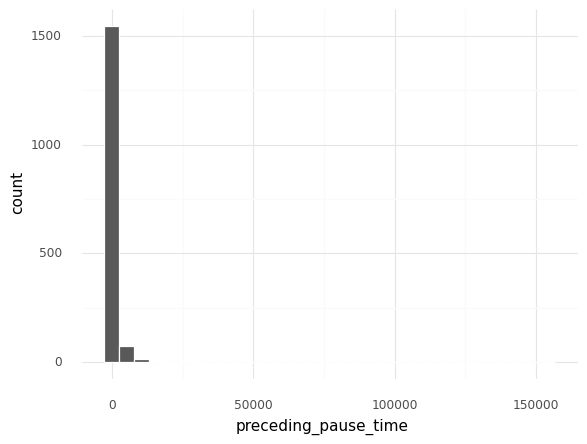

<ggplot: (75302949343)>

In [20]:
(
    p9.ggplot(X_train_sub) + 
    p9.geom_histogram(p9.aes('preceding_pause_time'), bins=30, color='white') + 
    p9.theme_minimal()
)

c:\Users\alexa\Anaconda3\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_bin : Removed 901 rows containing non-finite values.


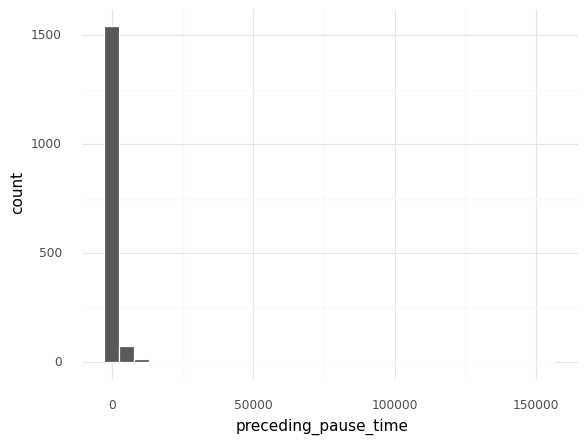

<ggplot: (75303084270)>

In [21]:
(
    p9.ggplot(X_train_sub.iloc[4:]) + 
    p9.geom_histogram(p9.aes('preceding_pause_time'), bins=30, color='white') + 
    p9.theme_minimal()
)

c:\Users\alexa\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


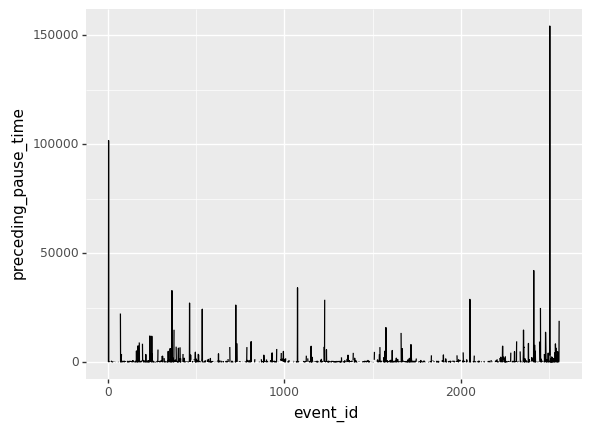

<ggplot: (75305261493)>

In [22]:
(
    p9.ggplot(X_train_sub) + 
    p9.geom_line(p9.aes('event_id', 'preceding_pause_time'))
)

# longest pause was ~2 minutes ... relatively little planning time ...
# might relate to data collection method. Mechanical Turk issued inactivity warning after 2 min.
# but that hardly seems like a fair planning time.

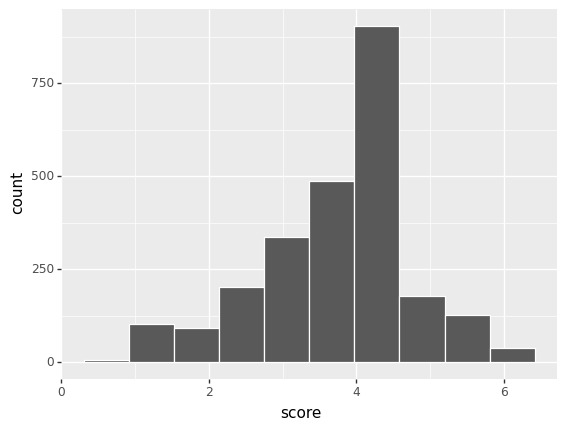

<ggplot: (75305288626)>

In [23]:
# what's the overall score distr look like?
(
    p9.ggplot(y_train) + 
    p9.geom_histogram(p9.aes('score'), bins=10, color='white')
)

In [24]:
X_train_marginals_sum_wrt_time = (
    X_train_sub
    .groupby('id')
    [
        ['activity_' + x for x in ACTIVITY_CATEGORIES] 
        + ['is_new_burst_start'] 
        + ['is_new_burst_start_' + x for x in ACTIVITY_CATEGORIES]
    ]
    .agg(sum)
    )
X_train_marginals_sum_wrt_time['delete_insert_ratio'] = (
    X_train_marginals_sum_wrt_time['activity_Remove/Cut'] / 
    X_train_marginals_sum_wrt_time['activity_Input'] 
    )

In [25]:
X_train_marginals_sum_wrt_time

,activity_Nonproduction,activity_Input,activity_Remove/Cut,is_new_burst_start,is_new_burst_start_Nonproduction,is_new_burst_start_Input,is_new_burst_start_Remove/Cut,delete_insert_ratio
id,,,,,,,,
001519c8,120.0,2010.0,417.0,125,27.0,86.0,12.0,0.207463


In [26]:
X_train_marginals_central_tendency_wrt_time = (
    X_train_sub
    .groupby('id')
    .agg(
        pause_time_p50 = ('preceding_pause_time', np.median),
        burst_duration_mean = ('burst_duration', 'mean'),
        burst_duration_p50 = ('burst_duration', np.median)
        )
    )

In [27]:
X_train_marginals_central_tendency_wrt_time

,pause_time_p50,burst_duration_mean,burst_duration_p50
id,,,
001519c8,91.0,9603.757137,8086.0


In [28]:
X_train_marginals_extremes_wrt_time = (
    X_train_sub
    .groupby('id')
    .agg(
        pause_time_max=('preceding_pause_time', 'max'),
        # approximation to, next longest pause after first long planning pause
        pause_time_p99=('preceding_pause_time', lambda x: x.quantile(0.99)),
        burst_duration_max=('burst_duration', 'max'),
        total_time=('up_time', 'max')
        )
    )

In [29]:
X_train_marginals_extremes_wrt_time

,pause_time_max,pause_time_p99,burst_duration_max,total_time
id,,,,
001519c8,154136.0,14109.12,24633,1801969


In [30]:
from scipy.stats import lognorm

shape, location, scale = lognorm.fit(X_train_sub['preceding_pause_time'].dropna())
X_train_marginals_distr_params_wrt_time = pd.DataFrame({
    'id': [X_train_sub['id'][0]],
    'pauses_lognorm_shape': [shape], 
    'pauses_lognorm_location': [location],
    'pauses_lognorm_scale': [scale]
})

In [31]:
X_train_marginals_distr_params_wrt_time

,id,pauses_lognorm_shape,pauses_lognorm_location,pauses_lognorm_scale
0,001519c8,1.600439,0.650173,141.125479


In [32]:
X_train_marginals_wrt_time = pd.merge(
    X_train_marginals_sum_wrt_time, 
    X_train_marginals_central_tendency_wrt_time,
    how='left',
    on=['id']
    )

X_train_marginals_wrt_time = pd.merge(
    X_train_marginals_wrt_time, 
    X_train_marginals_extremes_wrt_time,
    how='left',
    on=['id']
    )

X_train_marginals_wrt_time = (
    X_train_marginals_wrt_time
    .assign(writing_speed = lambda x: (x.activity_Input + x['activity_Remove/Cut']) / x.total_time)
    )

In [33]:
X_train_marginals_wrt_time

,activity_Nonproduction,activity_Input,activity_Remove/Cut,is_new_burst_start,is_new_burst_start_Nonproduction,is_new_burst_start_Input,is_new_burst_start_Remove/Cut,delete_insert_ratio,pause_time_p50,burst_duration_mean,burst_duration_p50,pause_time_max,pause_time_p99,burst_duration_max,total_time,writing_speed
id,,,,,,,,,,,,,,,,
001519c8,120.0,2010.0,417.0,125,27.0,86.0,12.0,0.207463,91.0,9603.757137,8086.0,154136.0,14109.12,24633,1801969,0.001347


In [34]:
X_train_by_window = (
    X_train_sub
    .groupby(['id', 'window_30s'])
    [
        ['activity_' + x for x in ACTIVITY_CATEGORIES] 
        + ['is_new_burst_start'] 
        + ['is_new_burst_start_' + x for x in ACTIVITY_CATEGORIES]
    ]
    .agg(sum)
    .astype(float)
    .reset_index(drop=False)
    )

X_train_by_window['delete_insert_ratio'] = (
    X_train_by_window['activity_Remove/Cut'] / 
    X_train_by_window['activity_Input'] 
    )

X_train_by_window['window_30s_idx'] = X_train_by_window.index

In [35]:
X_train_by_window.head(10)

,id,window_30s,activity_Nonproduction,activity_Input,activity_Remove/Cut,is_new_burst_start,is_new_burst_start_Nonproduction,is_new_burst_start_Input,is_new_burst_start_Remove/Cut,delete_insert_ratio,window_30s_idx
0,001519c8,"(0, 30000]",2.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0
1,001519c8,"(30000, 60000]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1
2,001519c8,"(60000, 90000]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2
3,001519c8,"(90000, 120000]",1.0,61.0,2.0,1.0,0.0,1.0,0.0,0.032787,3
4,001519c8,"(120000, 150000]",0.0,0.0,3.0,1.0,0.0,0.0,1.0,inf,4
5,001519c8,"(150000, 180000]",1.0,71.0,21.0,3.0,1.0,1.0,1.0,0.295775,5
6,001519c8,"(180000, 210000]",9.0,16.0,7.0,2.0,0.0,2.0,0.0,0.437500,6
7,001519c8,"(210000, 240000]",0.0,18.0,24.0,2.0,0.0,1.0,1.0,1.333333,7
8,001519c8,"(240000, 270000]",6.0,17.0,9.0,4.0,1.0,2.0,1.0,0.529412,8
9,001519c8,"(270000, 300000]",0.0,52.0,20.0,3.0,0.0,2.0,1.0,0.384615,9


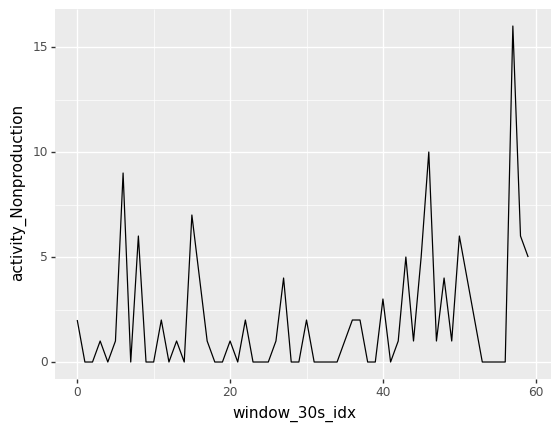

<ggplot: (75305355855)>

In [36]:
(
    p9.ggplot(X_train_by_window) + 
    p9.geom_line(p9.aes('window_30s_idx', 'activity_Nonproduction'))
)

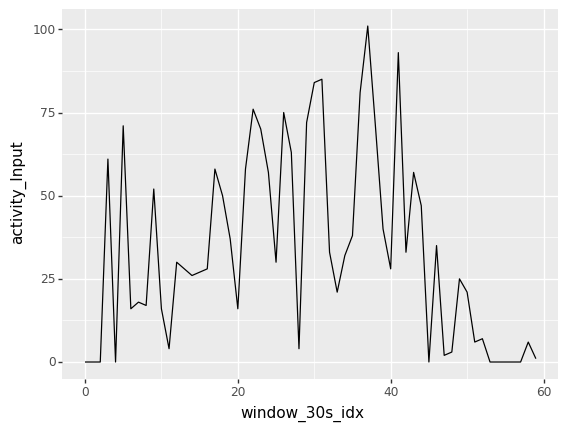

<ggplot: (75305386114)>

In [37]:
(
    p9.ggplot(X_train_by_window) + 
    p9.geom_line(p9.aes('window_30s_idx', 'activity_Input'))
)

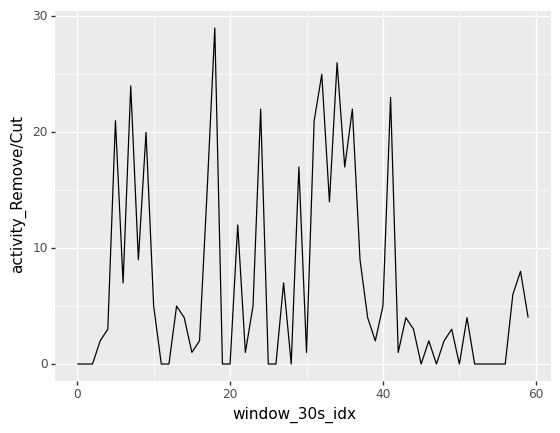

<ggplot: (75305419138)>

In [38]:
(
    p9.ggplot(X_train_by_window) + 
    p9.geom_line(p9.aes('window_30s_idx', 'activity_Remove/Cut'))
)

c:\Users\alexa\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 3 rows containing missing values.


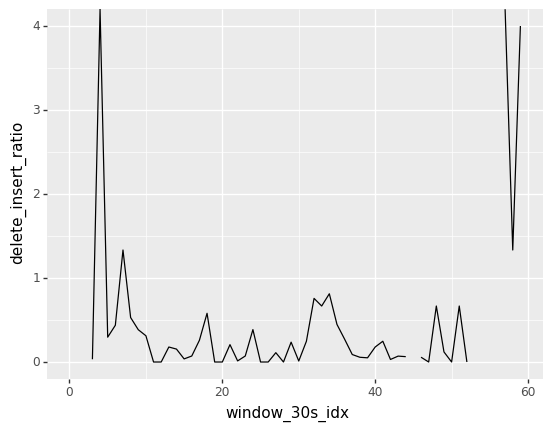

<ggplot: (75305453719)>

In [39]:
(
    p9.ggplot(X_train_by_window) + 
    p9.geom_line(p9.aes('window_30s_idx', 'delete_insert_ratio'))
)

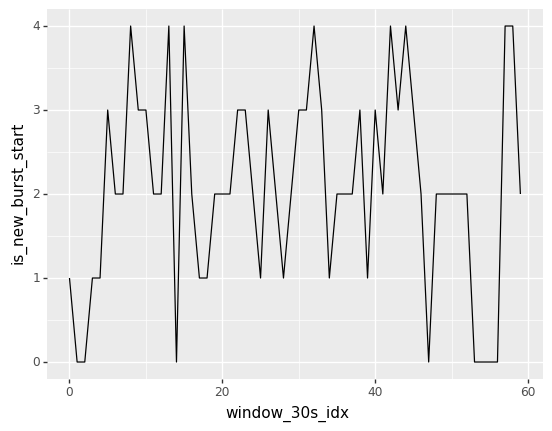

<ggplot: (75305486493)>

In [40]:
(
    p9.ggplot(X_train_by_window) + 
    p9.geom_line(p9.aes('window_30s_idx', 'is_new_burst_start'))
)

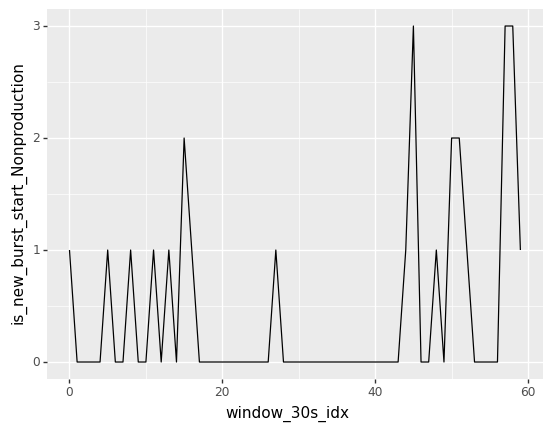

<ggplot: (75305453632)>

In [43]:
(
    p9.ggplot(X_train_by_window) + 
    p9.geom_line(p9.aes('window_30s_idx', 'is_new_burst_start_Nonproduction'))
)

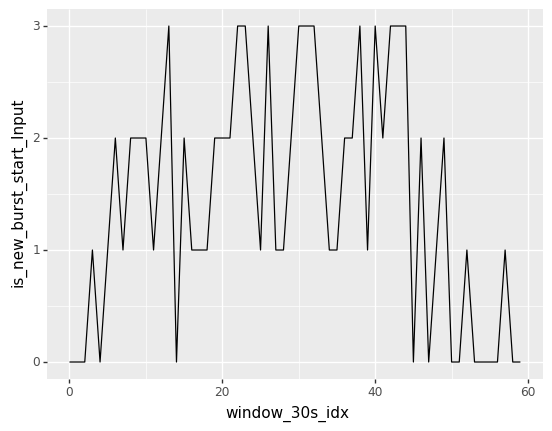

<ggplot: (75305552936)>

In [44]:
(
    p9.ggplot(X_train_by_window) + 
    p9.geom_line(p9.aes('window_30s_idx', 'is_new_burst_start_Input'))
)

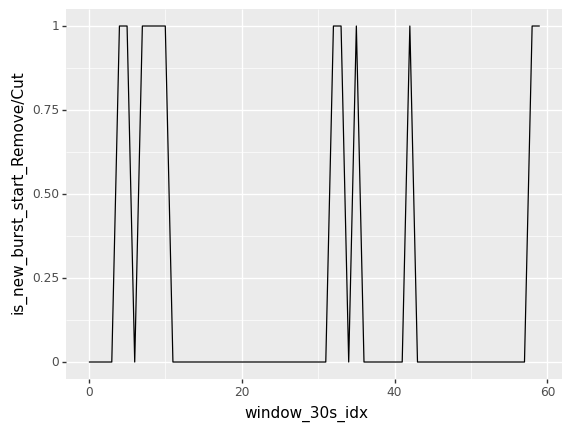

<ggplot: (75305427779)>

In [45]:
(
    p9.ggplot(X_train_by_window) + 
    p9.geom_line(p9.aes('window_30s_idx', 'is_new_burst_start_Remove/Cut'))
)

In [41]:
X_train_windows_variation = (
    X_train_by_window
    .drop(columns=['window_30s', 'window_30s_idx'])
    .groupby(['id'])
    .agg(np.std)
    )

In [42]:
X_train_windows_variation

,activity_Nonproduction,activity_Input,activity_Remove/Cut,is_new_burst_start,is_new_burst_start_Nonproduction,is_new_burst_start_Input,is_new_burst_start_Remove/Cut,delete_insert_ratio
id,,,,,,,,
001519c8,3.039244,29.025121,8.569605,1.205449,0.810245,1.079339,0.403376,NaN
